In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm


import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary
print(torch.__version__)

import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Set TensorFlow to use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

2.0.1+cpu


In [2]:
def count_images_in_directory(directory):
    image_extensions = ['.jpg', '.jpeg', '.png']  # Add more extensions if needed
    image_count = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_count += 1

    return image_count

directory_path = "102flowers"
print("Total number of images in the directory: ", count_images_in_directory(directory_path))



Total number of images in the directory:  8189


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
#read .mat file
import scipy.io
mat1= scipy.io.loadmat('imagelabels.mat')
mat1['labels'][0]

array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [5]:
#Define the dataset class for the Oxford 102 flowers dataset
class OxfordFlowersDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = []
        self.labels = []

        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('jpg'):
                    self.image_names.append(os.path.join(root, file))
                    labels=mat1['labels'][0][int(file.split('_')[1].split('.')[0])-1]
                    self.labels.append(labels-1)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image = Image.open(self.image_names[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
#defining the train validation and test sets
dataset = OxfordFlowersDataset(directory_path, transform=transform)

#count the total number of images in the dataset
print("Total number of images in the dataset: ", len(dataset))



Total number of images in the dataset:  8189


In [6]:
#read .mat file
import scipy.io
mat2= scipy.io.loadmat('setid.mat')
mat2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [7]:
trnid = mat2['trnid']
valid = mat2['valid']
tstid = mat2['tstid']

In [8]:
# Split the dataset into training, validation, and test sets using the data splits provided in the dataset:
train_set = torch.utils.data.Subset(dataset, trnid[0] - 1)
valid_set = torch.utils.data.Subset(dataset, valid[0] - 1)
test_set = torch.utils.data.Subset(dataset, tstid[0] - 1)

#count the total number of images in the each set
print("Total number of images in the training set: ", len(train_set))
print("Total number of images in the validation set: ", len(valid_set))
print("Total number of images in the test set: ", len(test_set))

Total number of images in the training set:  1020
Total number of images in the validation set:  1020
Total number of images in the test set:  6149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


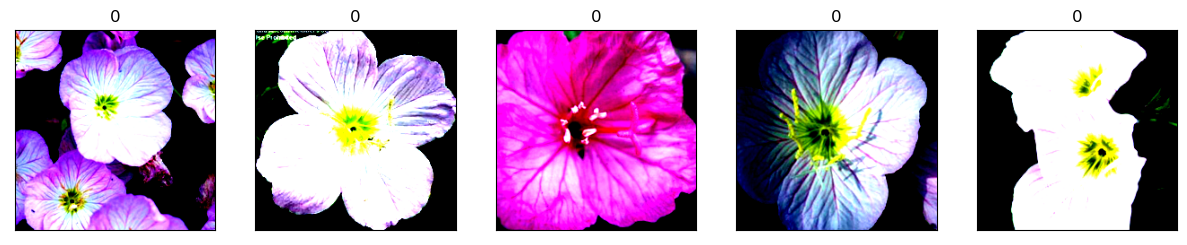

In [9]:
#visualize the first 5 images in the training set with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
    image, label = train_set[i]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


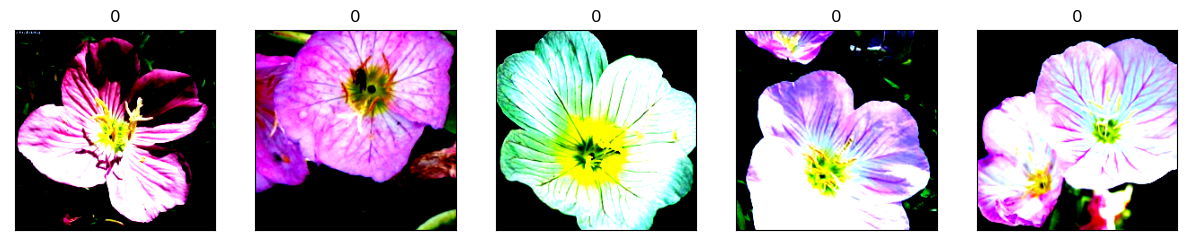

In [10]:
#visualize the first 5 images in the validation set with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
    image, label = valid_set[i]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [11]:
#Define the data loaders:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True,pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True,pin_memory=True)

#Define the model:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 102)

#Define the loss function and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Define the device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

summary(model, input_size=(1, 3, 224, 224))    


c:\Users\KIIT\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KIIT\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 102]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [12]:
#move the model to the device
model = model.to(device)

#Define the training loop:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, save_path):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        valid_accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            #explicitly delete the intermediate variables to free up GPU memory
            del images
            del labels
            del outputs
            torch.cuda.empty_cache()

        model.eval()
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.long())

            valid_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            valid_accuracy += torch.sum(preds == labels.data)

            #explicitly delete the intermediate variables to free up GPU memory
            del images
            del labels
            del outputs
            torch.cuda.empty_cache()

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_accuracy / len(valid_loader.dataset)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch: {epoch + 1}/{num_epochs}.. ",
              f"Training Loss: {train_loss:.3f}.. ",
              f"Validation Loss: {valid_loss:.3f}.. ",
              f"Validation Accuracy: {valid_accuracy:.3f}")

    torch.save(model.state_dict(), save_path)

    return train_losses, valid_losses, valid_accuracies

In [13]:
#Train the model:
train_losses, valid_losses, valid_accuracies = train(model, criterion, optimizer, train_loader, valid_loader, 10, device, 'resnet50_flowers.pth')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1/10..  Training Loss: 3.659..  Validation Loss: 6.713..  Validation Accuracy: 0.135


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2/10..  Training Loss: 1.332..  Validation Loss: 2.318..  Validation Accuracy: 0.481


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#Plot the training and validation losses and accuracies:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(train_losses, label='Training Loss')
axes[0].plot(valid_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Losses')
axes[0].legend()
axes[1].plot(valid_accuracies.cpu, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
plt.show()

#test the model
def test(model, test_loader, device):

    model.eval()
    test_accuracy = 0.0

    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        test_accuracy += torch.sum(preds == labels.data)

        #explicitly delete the intermediate variables to free up GPU memory
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()

    test_accuracy = test_accuracy / len(test_loader.dataset)

    print(f"Test Accuracy: {test_accuracy:.3f}")

test(model, test_loader, device)


In [ ]:

#visualize the first 5 images in the test set with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
    image, label = test_set[i]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()


In [ ]:

#visualize the first 5 images in the test set with their predicted labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
    image, label = test_set[i]
    image = image.to(device)
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(pred.item())
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()
